In [18]:
%%capture --no-stderr
%pip install -U langgraph langchain_community langchain_anthropic langchain_experimental

In [19]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("TAVILY_API_KEY")

In [20]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langgraph.graph import MessagesState

from typing import Literal
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI

from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent

from pydantic import BaseModel, Field
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.prebuilt import ToolNode

from langchain_core.prompts.prompt import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.schema import HumanMessage, AIMessage

In [21]:
# @tool
# def tavily(query:str):
#     """Executes Tavily Search and getts the response for the query Asked"""
#     tavily_tool = TavilySearchResults(max_results=5)
#     return tavily_tool.invoke(query)
tavily_tool = TavilySearchResults(max_results=5)

In [22]:
class AgentState(MessagesState):
    next: str

In [23]:
members = ["researcher", "validator"]
options = members + ["FINISH"]

In [24]:
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker/agent to act next. Each worker will perform a"
    " task and respond with their results and status. You must trigger the workers"
    f" in the following sequence: {members}, and finally respond with FINISH."
    " Do not skip any workers, and always ensure all tasks are completed in the correct order."
)

In [25]:

class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal[*options]

In [26]:
# llm = ChatOpenAI()

from langchain_ollama import ChatOllama

llm = ChatOllama(model="llama3.2")

In [27]:
def supervisor_node(state: AgentState) -> AgentState:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    next_ = response["next"]
    if next_ == "FINISH":
        next_ = END

    return {"next": next_}

In [28]:

research_agent = create_react_agent(
    llm, tools=[tavily_tool], state_modifier="You are a researcher who receives search results."
)


def research_node(state: AgentState) -> AgentState:
    result = research_agent.invoke(state)
    return {
        "messages": [
            HumanMessage(content=result["messages"][-1].content, name="researcher")
        ]
    }


In [29]:
@tool
def validate_the_content(content: str, topic: str):
    """This function checks the relevancy of the content to the topic by using LLM and return the value. """
    class Relevant(BaseModel):
        relevancy: str = Field(
            description="A string that holds either 'RELEVANT' or 'NOT RELEVANT'."
        )
    model = llm.bind_tools(Relevant)
    system_message = SystemMessage(content="""
    You are an expert evaluator. Your task is to determine whether the given content 
    is relevant to the provided topic. Your output should be structured as follows:
    {
        "relevancy": "RELEVANT" or "NOT RELEVANT"
    }
    Analyze the content carefully and strictly adhere to the format.
    """)
    user_input = f"""
    CONTENT:
    ------
    {content}

    TOPIC:
    ------
    {topic}
    """
    response = model.invoke({"messages": [system_message, user_input]})
    return response

In [30]:

validate_agent = create_react_agent(
    llm, tools=[validate_the_content], state_modifier="You are a validator who validates and confirms if the infromation in 'RELEVANT' or 'NOT RELEVANT' "
)

def validate_node(state: AgentState) -> AgentState:
    result = validate_agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name="validator")]
    }


In [31]:
builder = StateGraph(AgentState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("validator", validate_node)

In [32]:
for member in members:
    builder.add_edge(member, "supervisor")

builder.add_conditional_edges("supervisor", lambda state: state["next"])

builder.add_edge(START, "supervisor")

graph = builder.compile()

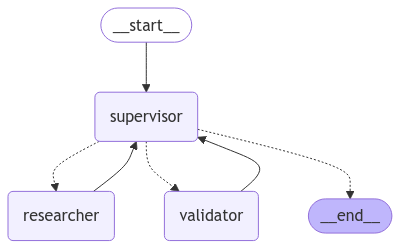

In [33]:
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:
for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "Gather the information on 26/11 attach in Mumbai India",
            )
        ]
    },
    subgraphs=True,
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:dae8c783-ac00-d973-0c84-1ab38464e25d',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2024-12-01T06:51:46.115585Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1417023458, 'load_duration': 19492000, 'prompt_eval_count': 207, 'prompt_eval_duration': 632486000, 'eval_count': 26, 'eval_duration': 761372000, 'message': Message(role='assistant', content='', images=None, tool_calls=[ToolCall(function=Function(name='tavily_search_results_json', arguments={'query': '26/11 attack in Mumbai, India'}))])}, id='run-2a6cfe5b-b162-4063-8e2a-062475760979-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '26/11 attack in Mumbai, India'}, 'id': '1eb35cce-f4dc-44c9-860f-a75060ae64d8', 'type': 'tool_call'}], usage_metadata={'input_tokens': 207, 'output_tokens': 26, 'total_tokens': 233})]}})
----
(('researcher:dae8c783-ac00-d973-0c8

KeyboardInterrupt: 